In [1]:
import os
import cv2


categories = ['with_mask','without_mask']
dataset = []
for category in categories:
    path = os.path.join('dataset',category)
    label = categories.index(category)
    for file in os.listdir(path):
        img_path = os.path.join(path,file)
        img = cv2.imread(img_path)
        img = cv2.resize(img,(224,224))
        dataset.append([img,label])

In [2]:
categories.index('with_mask'),categories.index('without_mask')

(0, 1)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def render_image(img):
    plt.imshow(img)
    plt.show()

### Shuffling the dataset

In [5]:
import random

def shuffle(data):
    random.shuffle(data)

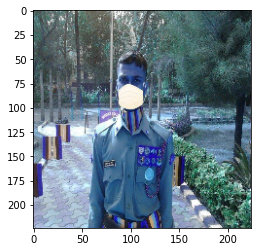

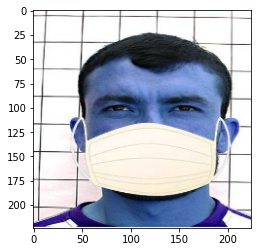

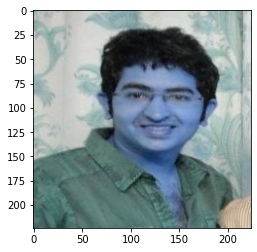

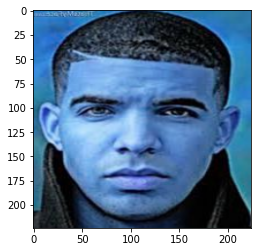

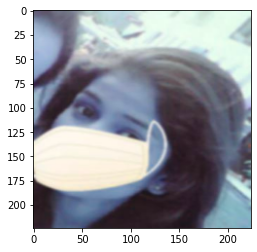

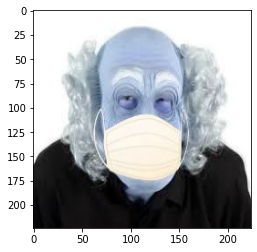

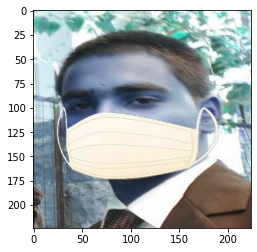

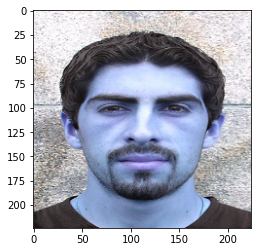

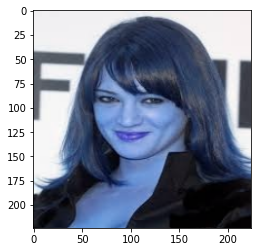

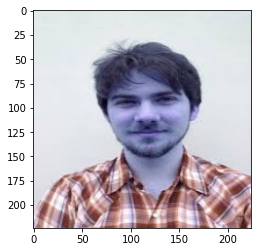

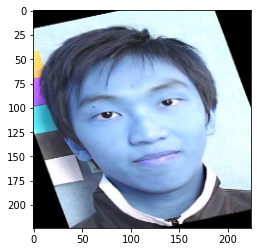

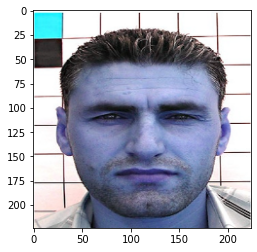

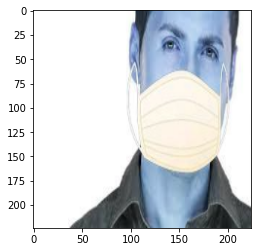

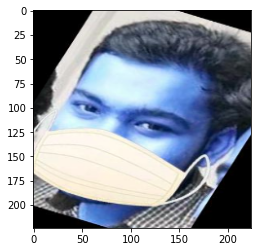

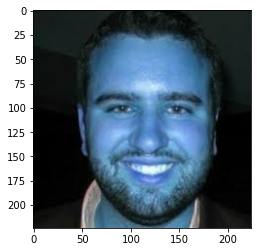

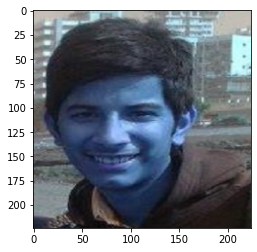

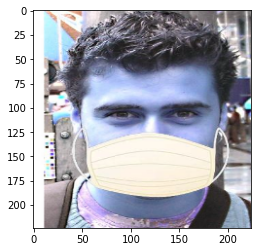

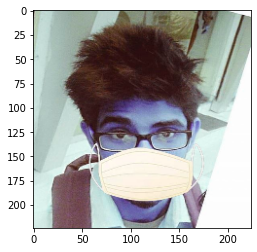

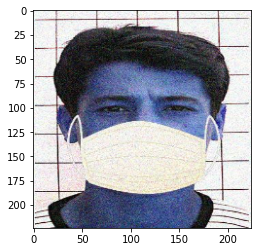

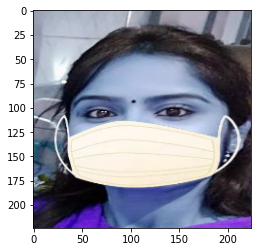

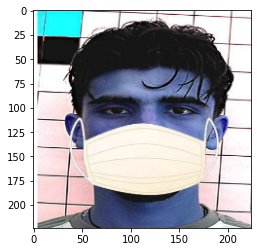

In [6]:
shuffle(dataset)

for i in range(len(dataset)):
    render_image(dataset[i][0])
    if i==20:
        break

### **Seperating data and label**

In [7]:
def get_data_label():
    data = []
    label = []
    for img,annotation in dataset:
        data.append(img)
        label.append(annotation)
    return np.array(data), np.array(label)

In [8]:
data, label = get_data_label()
print("Shape of data: ",data.shape)
print("Shape of label: ",label.shape)

Shape of data:  (1376, 224, 224, 3)
Shape of label:  (1376,)


#### Scale data 

In [9]:
def scale_data(x):
    return x/255

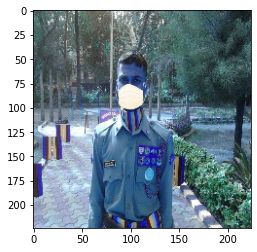

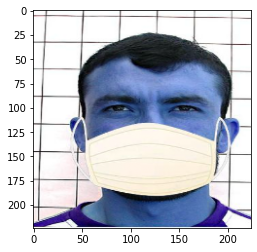

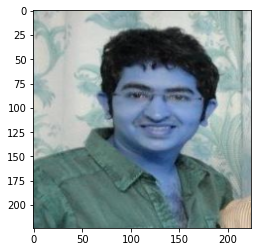

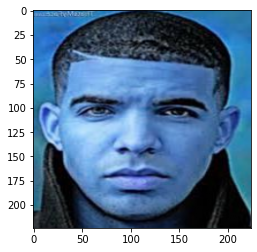

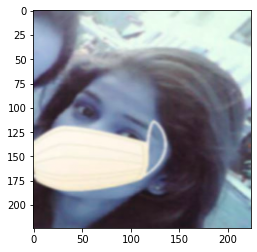

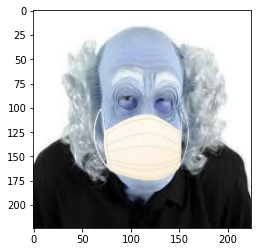

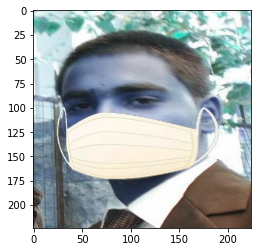

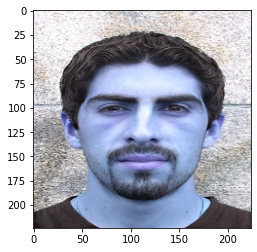

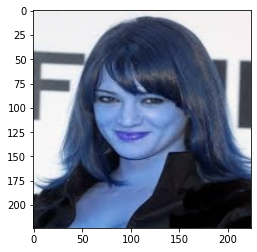

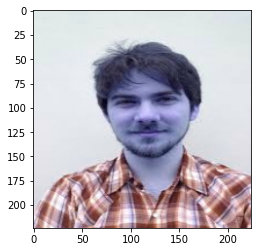

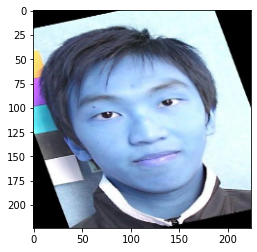

In [10]:
data = scale_data(data)

for index,img in enumerate(data):
    render_image(img)
    if index==10:
        break

### Splitting train and test data

In [11]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(data,label,test_size = 0.2)

In [12]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((1100, 224, 224, 3), (1100,), (276, 224, 224, 3), (276,))

### Creating CNN model

In [13]:
from keras.applications.vgg16 import VGG16

#### **Loading VGG16 pre trained model**

In [14]:
vgg16_model = VGG16()

#### **Model**

In [15]:
from keras import Sequential
from keras.layers import Dense
import tensorflow as tf

class Model:
    def __init__(self,learning_rate,epochs,pre_trained):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.pre_trained = pre_trained
        self._model = Sequential()
        
    def init_model(self):
        for layer in self.pre_trained.layers[:-1]:
            self._model.add(layer)
        for layer in self._model.layers:
            layer.trainable = False
            
        self._model.add(Dense(1,activation='sigmoid'))
        self._model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss ='binary_crossentropy', metrics = ['accuracy'])
    
    
    def get_model(self):
        return self._model
    
    def train(self,X_train,Y_train,X_test,Y_test):
        self._model.fit(X_train,Y_train, epochs = self.epochs,validation_data = (X_test,Y_test))
        
        
    def predict(self,image):
        prediction = self._model.predict(image)
        return prediction[0][0]<0.3
            
            
    def get_summary(self):
        print(self._model.summary())

In [16]:
detector = Model(0.001,5,vgg16_model)

detector.init_model()
detector.train(X_train,Y_train,X_test,Y_test)

Epoch 1/5
35/35 [==============================] - 188s 5s/step - loss: 0.4845 - accuracy: 0.8127 - val_loss: 0.3499 - val_accuracy: 0.8877
Epoch 2/5
35/35 [==============================] - 196s 6s/step - loss: 0.2886 - accuracy: 0.9191 - val_loss: 0.2450 - val_accuracy: 0.9312
Epoch 3/5
35/35 [==============================] - 204s 6s/step - loss: 0.2206 - accuracy: 0.9391 - val_loss: 0.1997 - val_accuracy: 0.9493
Epoch 4/5
35/35 [==============================] - 208s 6s/step - loss: 0.1870 - accuracy: 0.9409 - val_loss: 0.2042 - val_accuracy: 0.9384
Epoch 5/5
35/35 [==============================] - 210s 6s/step - loss: 0.1619 - accuracy: 0.9564 - val_loss: 0.1616 - val_accuracy: 0.9565


In [17]:
detector.get_summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

### Video capture using cv2

In [34]:
def detect_mask(image):
    model = detector.get_model()
    prediction = model.predict(image.reshape(1,224,224,3))
    return prediction[0][0]<0.3

In [35]:
def draw_label(image,text,pos,bg_color):
    text_size = cv2.getTextSize(text,cv2.FONT_HERSHEY_SIMPLEX,1,cv2.FILLED)
    x1 = pos[0]
    x2 = pos[0] + text_size[0][0] + 2
    y1 = pos[1]
    y2 = pos[1] + text_size[0][1] - 2
    
    cv2.rectangle(image,pos,(x2,y2),bg_color,cv2.FILLED)
    cv2.putText(image,text,pos,cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),1,cv2.LINE_AA)

In [36]:
haar = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def detect_face(image):
    coods = haar.detectMultiScale(image)
    return coods

In [37]:
def run():
    capture = cv2.VideoCapture(0)

    while True:
        success, frame = capture.read()

        image = cv2.resize(frame,(224,224))
        prediction = detect_mask(image)

        if prediction:
            draw_label(frame,"Has mask",(30,30),(0,255,0))
            coordinates = detect_face(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))
            for x,y,w,h in coordinates:
                cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),3)
        else:
            draw_label(frame,"No mask",(30,30),(0,0,255))
            coordinates = detect_face(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))
            for x,y,w,h in coordinates:
                cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),3)

        cv2.imshow("Mask Detector",frame)

        if cv2.waitKey(1) & 0xFF == ord('x'):
            break

    cv2.destroyAllWindows()
    capture.release()

In [38]:
run()

In [39]:
model = detector._model

model.save('model.h5')

loaded_model = tf.keras.models.load_model('model.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2